In [1]:
import sys
import os

# 1. On récupère le dossier où se trouve le notebook
current_dir = os.getcwd()

# 2. On remonte d'un cran pour trouver la racine du projet
# (Si votre notebook est dans un sous-sous-dossier, répétez os.path.dirname une fois de plus)
project_root = os.path.dirname(current_dir)

# 3. On ajoute ce chemin à Python s'il n'y est pas déjà
if project_root not in sys.path:
    sys.path.append(project_root)

# 4. Vérification (optionnel)
print(f"Racine ajoutée : {project_root}")
print(f"Dossier 'src' détecté ? : {os.path.isdir(os.path.join(project_root, 'src'))}")

Racine ajoutée : /home/onyxia/work/Non-Gaussian-State-Space-Models
Dossier 'src' détecté ? : True


In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import poisson, nbinom
from tqdm import tqdm
import openpyxl


# particles library usage 
import particles
import particles.state_space_models as ssm
import particles.distributions as dists


# project related packages
import src.cox_simulation as cx
import utils.plots as pl
import src.creal_filter as cf 
import src.particle_filter as pf
import utils.load_data as ld

In [3]:
# --- CONFIGURATION GLOBALE ---
T_COMMON = 1000
GLOBAL_SEED = 42

# Dictionnaire pour stocker les résultats avant export
export_data = {}

# ==============================================================================
# SÉRIE 1 : Sans covariables (Phi=0.965)
# ==============================================================================
params_1 = {"phi": 0.965, "nu": 2.5, "c": 0.2}
# On utilise ta classe existante
sim1 = cx.CoxProcessSimulation(T=T_COMMON, **params_1, seed=1)
y0, h0, z0 = sim1.simulate(init="stationary")

export_data["Serie_1"] = {
    "params": str(params_1), # On stocke les params en string pour info
    "beta": "None",
    "df": pd.DataFrame({"y": y0, "h_true": h0})
}
print("✅ Série 1 générée.")

# ==============================================================================
# SÉRIE 2 : 1 Covariable (Bruit Blanc) + Intercept
# ==============================================================================
params_2 = {"phi": 0.8, "nu": 2.5, "c": 0.2}
rng = np.random.default_rng(2) # Seed spécifique pour les covariables

# Création manuelle des covariables comme dans ton exemple
X1 = np.column_stack([
    np.ones(T_COMMON),    # Intercept
    rng.normal(size=T_COMMON) # Covariable 1
])
beta1 = np.array([-0.5, 0.3])
tau1 = np.ones(T_COMMON)

sim2 = cx.CoxProcessSimulation(T=T_COMMON, **params_2, seed=2)
# Appel de ta méthode simulate avec les arguments optionnels
y1, h1, z1, expo1 = sim2.simulate(X=X1, beta=beta1, tau=tau1, return_exposure=True)

df2 = pd.DataFrame({"y": y1, "h_true": h1})
# On ajoute les colonnes de X dans le dataframe pour ne rien perdre
df2["X_intercept"] = X1[:, 0]
df2["X_cov1"] = X1[:, 1]

export_data["Serie_2"] = {
    "params": str(params_2),
    "beta": str(list(beta1)),
    "df": df2
}
print("✅ Série 2 générée.")

# ==============================================================================
# SÉRIE 3 : 2 Covariables (Bruit Blanc + AR1) + Intercept
# ==============================================================================
params_3 = {"phi": 0.8, "nu": 2.5, "c": 0.2}
rng = np.random.default_rng(3)

# Construction AR(1) manuelle
x_ar = np.zeros(T_COMMON)
for t in range(1, T_COMMON):
    x_ar[t] = 0.8 * x_ar[t - 1] + rng.normal()

X2 = np.column_stack([
    np.ones(T_COMMON),    # Intercept
    rng.normal(size=T_COMMON), # Covariable 1
    x_ar                  # Covariable 2 (AR1)
])
beta2 = np.array([-0.5, 0.4, -0.3])
tau2 = np.ones(T_COMMON)

sim3 = cx.CoxProcessSimulation(T=T_COMMON, **params_3, seed=3)
y2, h2, z2, expo2 = sim3.simulate(X=X2, beta=beta2, tau=tau2, return_exposure=True)

df3 = pd.DataFrame({"y": y2, "h_true": h2})
df3["X_intercept"] = X2[:, 0]
df3["X_cov1"] = X2[:, 1]
df3["X_cov2"] = X2[:, 2]

export_data["Serie_3"] = {
    "params": str(params_3),
    "beta": str(list(beta2)),
    "df": df3
}
print("✅ Série 3 générée.")



✅ Série 1 générée.
✅ Série 2 générée.
✅ Série 3 générée.


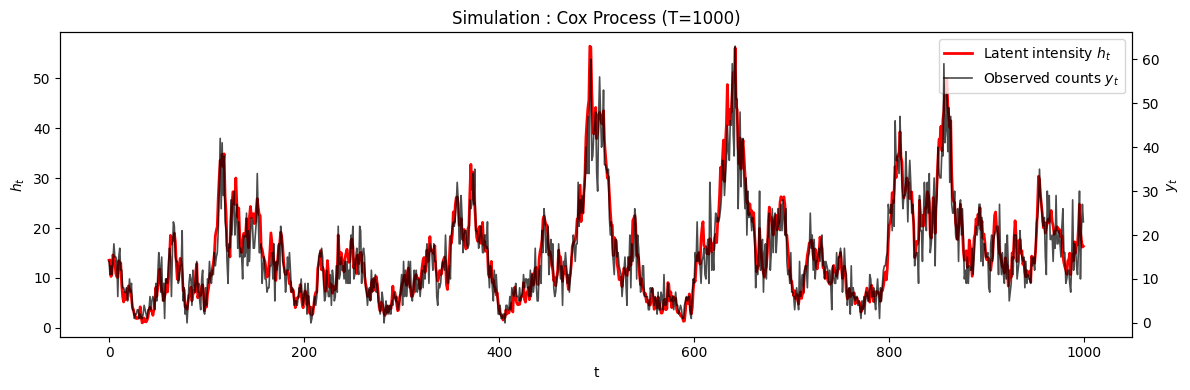

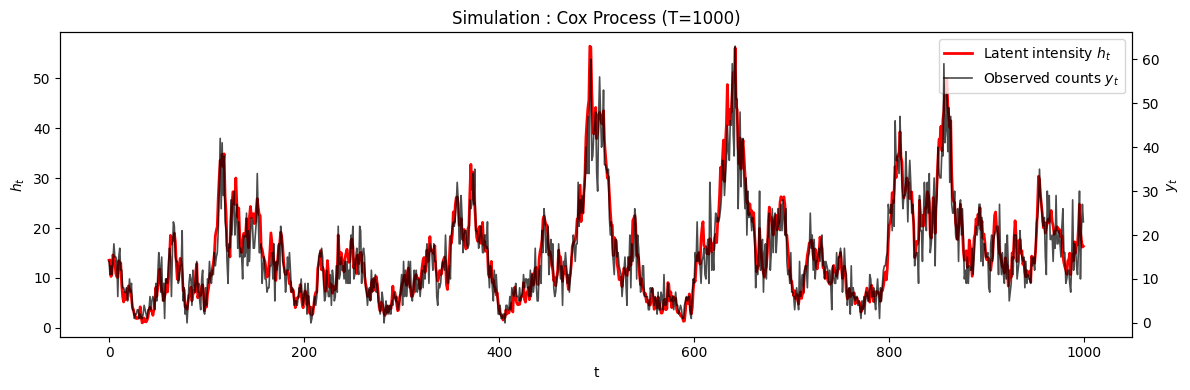

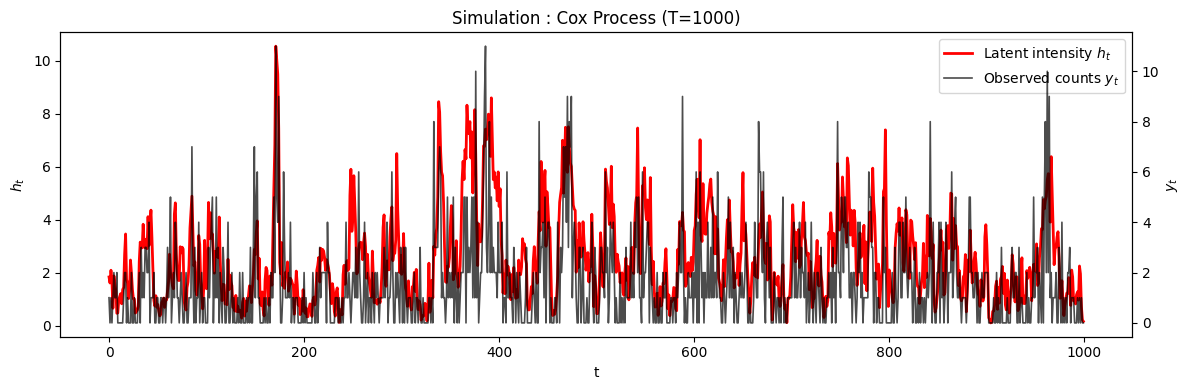

In [7]:
pl.plot_overlay_clean(y0, h0, T_show=1000, start=0)
pl.plot_overlay_clean(y1, h1, T_show=1000, start=0)
pl.plot_overlay_clean(y2, h2, T_show=1000, start=0)

In [ ]:
# ==============================================================================
# EXPORT EXCEL
# ==============================================================================
#filename = "data_groupe_T1000.xlsx"
#with pd.ExcelWriter(filename, engine='openpyxl') as writer:
#    # On crée une feuille "INFO" pour stocker les betas et params
#    infos = []
#    for k, v in export_data.items():
#        infos.append({"Serie": k, "Params": v["params"], "Beta": v["beta"]})
#    pd.DataFrame(infos).to_excel(writer, sheet_name="INFO", index=False)
#    
#    # On sauvegarde chaque série dans sa feuille
#    for k, v in export_data.items():
#        v["df"].to_excel(writer, sheet_name=k, index=False)
#
#print(f"\n📁 Fichier '{filename}' prêt à être partagé !")


📁 Fichier 'data_groupe_T1000.xlsx' prêt à être partagé !


✅ Chargé: Serie_1 (Beta: None)


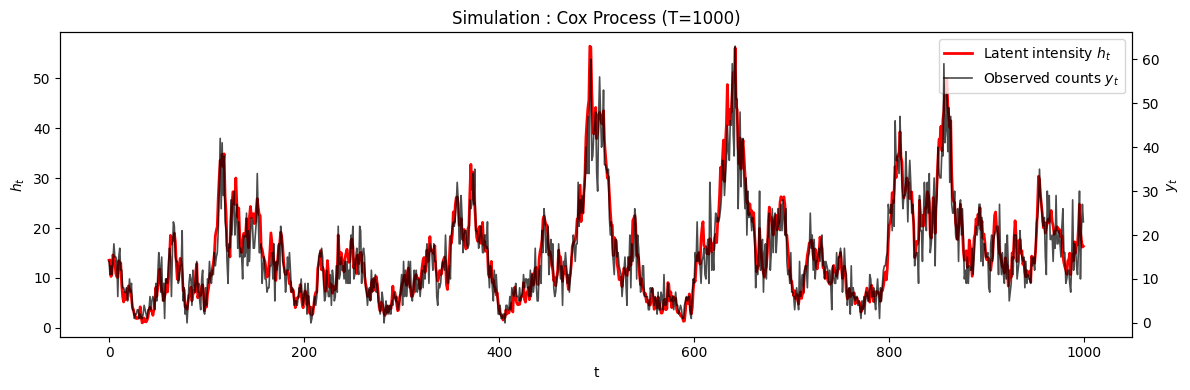

In [4]:
excel_path = os.path.join(project_root, "data", "data_groupe_T1000.xlsx")
y1, X1, h1, beta1, p1 = ld.load_data(excel_path, "Serie_1")
pl.plot_overlay_clean(y1, h1, T_show=1000, start=0)

✅ Chargé: Serie_2 (Beta: [-0.5  0.3])


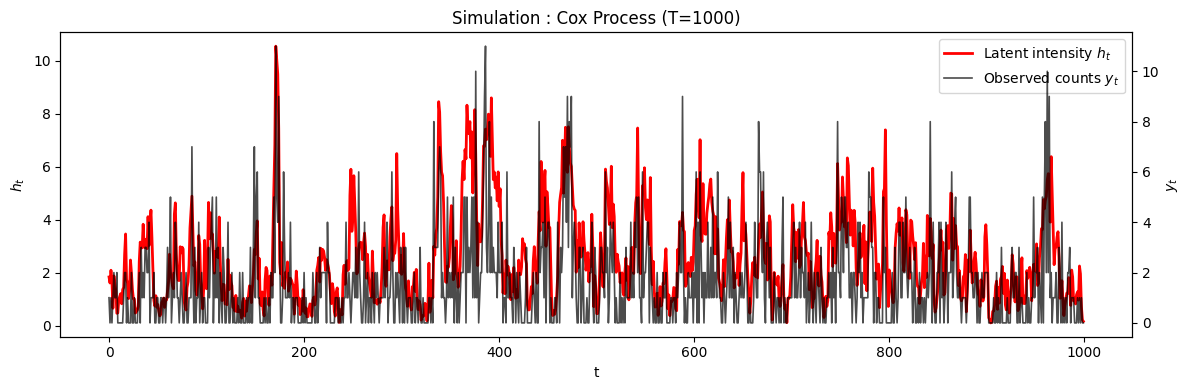

In [5]:
y2, X2, h2, beta2, p2 = ld.load_data(excel_path, "Serie_2")
pl.plot_overlay_clean(y2, h2, T_show=1000, start=0)


✅ Chargé: Serie_3 (Beta: [-0.5  0.4 -0.3])


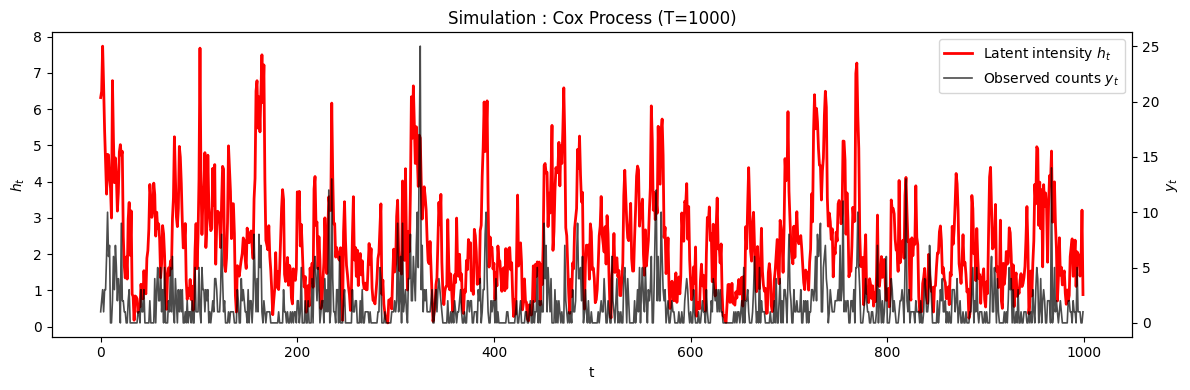

In [6]:
y3, X3, h3, beta3, p3 = ld.load_data(excel_path, "Serie_3")
pl.plot_overlay_clean(y3, h3, T_show=1000, start=0)


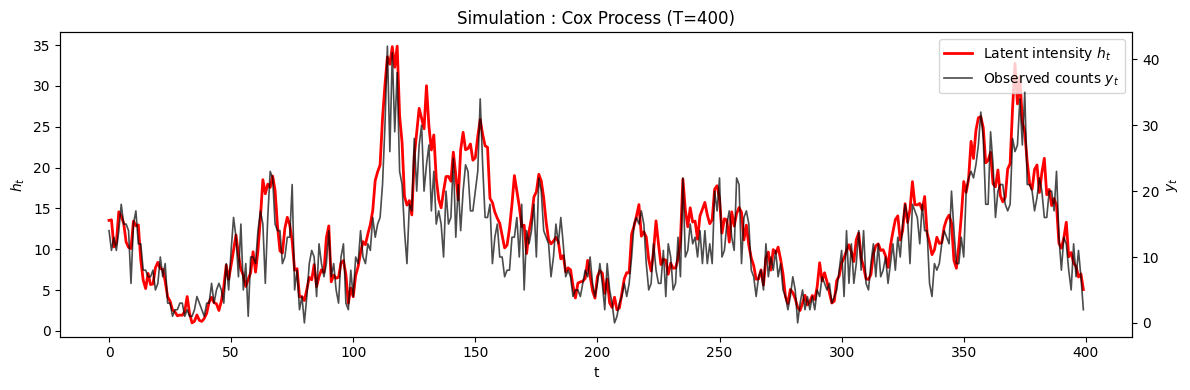

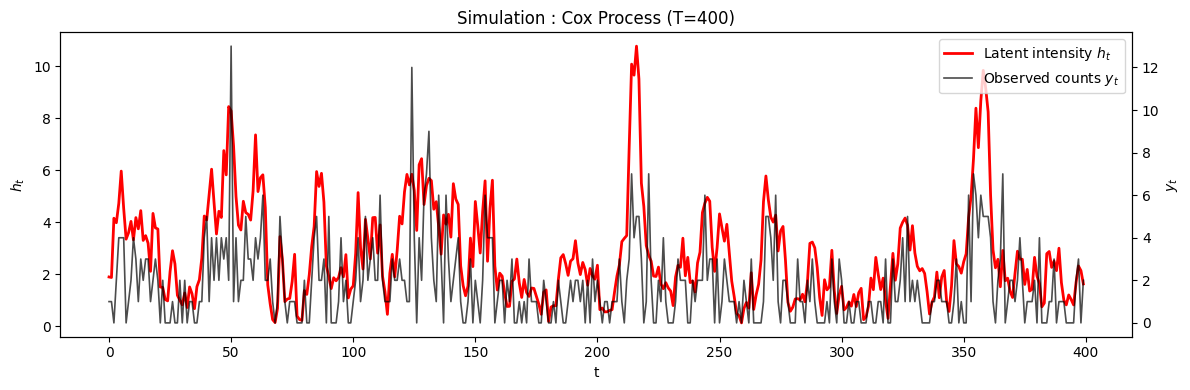

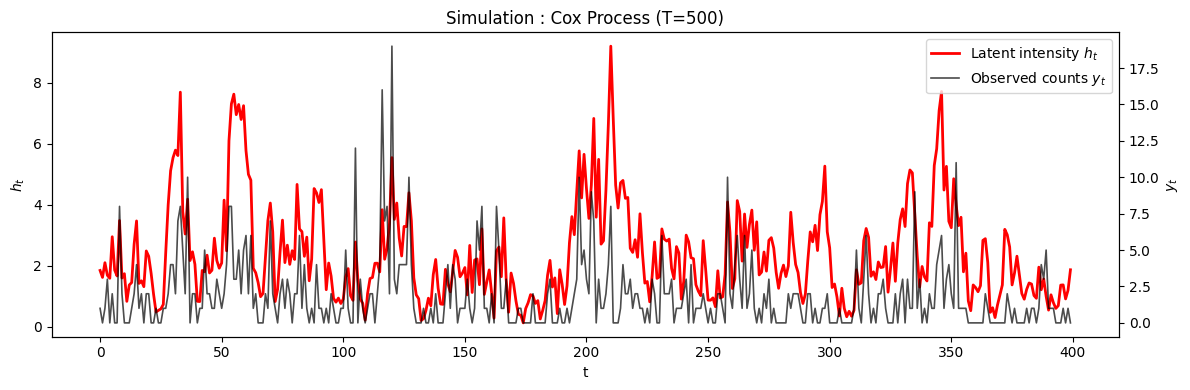

In [ ]:
# version sans covariable 

TRUE_PARAMS = {"phi": 0.965, "nu": 2.5, "c": 0.2}
T = 400
seed = 1

sim = cx.CoxProcessSimulation(T=T, **TRUE_PARAMS, seed=seed)

# y_t | h_t ~ Poisson(h_t)
y0, h0, z0 = sim.simulate()

# (optionnel) plot
# pl.plot_series({"h_t": h0, "y_t": y0}, title="Cox sans covariables")

# version exacte comme mentionnée dans le papier avec 1 covariable qui est un bruit blanc 

TRUE_PARAMS = {"phi": 0.8, "nu": 2.5, "c": 0.2}
T = 400
seed = 1

rng = np.random.default_rng(seed)

# covariables: intercept + une variable
X = np.column_stack([
    np.ones(T),
    rng.normal(size=T)
])

beta = np.array([-0.5, 0.3])   # coefficients associés aux x 
tau = np.ones(T)               # exposition (optionnel; tau=1 partout)

sim = cx.CoxProcessSimulation(T=T, **TRUE_PARAMS, seed=seed)

y1, h1, z1, expo1 = sim.simulate(X=X, beta=beta, tau=tau, return_exposure=True)
# y, h, z, expo = sim.simulate(X=X, beta=beta, tau=tau, return_exposure=True)

# Série 2 : intercept + 2 covariables (bruit blanc + AR(1))

TRUE_PARAMS = {"phi": 0.8, "nu": 2.5, "c": 0.2}
T = 500
seed = 1

# covariable 1 : bruit blanc
x1 = rng.normal(size=T)

# covariable 2 : AR(1)
x2 = np.zeros(T)
for t in range(1, T):
    x2[t] = 0.8 * x2[t - 1] + rng.normal()

X2 = np.column_stack([
    np.ones(T),   # intercept
    x1,
    x2
])

beta2 = np.array([-0.5, 0.4, -0.3])  # taille = 3
tau2 = np.ones(T)

sim2 = cx.CoxProcessSimulation(T=T, **TRUE_PARAMS, seed=seed + 1)
y2, h2, z2, expo2 = sim2.simulate(X=X2, beta=beta2, tau=tau2, return_exposure=True)

# pl.plot_time_series(y, h, T_show=1000, start=0, use_bars=False)
# pl.plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
# pl.plot_acf_h(h, lags=40, burn=200)
# pl.plot_acf_y(y, lags=40, burn=200)
pl.plot_overlay_clean(y0, h0, T_show=400, start=0)
pl.plot_overlay_clean(y1, h1, T_show=400, start=0)
pl.plot_overlay_clean(y2, h2, T_show=400, start=0)

In [ ]:
import pandas as pd
import numpy as np
import utils.cox_simulation as cx  # Assure-toi que l'import est correct selon ton dossier

# Configuration globale
T = 1000
SEED_GLOBAL = 0  # Pour que la génération soit reproductible

# Définition des 3 scénarios
scenarios = [
    {
        "name": "Serie_A_Standard",
        "desc": "Persistance forte (Ton exemple)",
        "params": {"phi": 0.98, "nu": 2.5, "c": 0.2, "beta": 1}
    },
    {
        "name": "Serie_B_Moyenne",
        "desc": "Persistance modérée, moins de variance",
        "params": {"phi": 0.80, "nu": 1.5, "c": 0.5, "beta": 1}
    },
    {
        "name": "Serie_C_Difficile",
        "desc": "Faible persistance, plus de bruit (difficile à estimer)",
        "params": {"phi": 0.50, "nu": 4.0, "c": 1.0, "beta": 1}
    }
]

# Création du fichier Excel
filename = "cox_dataset_groupe.xlsx"

with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    
    summary_data = []
    
    for i, scenar in enumerate(scenarios):
        # 1. Simulation
        # On change la seed à chaque fois pour l'indépendance
        sim = cx.CoxProcessSimulation(
            T=T,
            phi=scenar["params"]["phi"],
            nu=scenar["params"]["nu"],
            c=scenar["params"]["c"],
            seed=SEED_GLOBAL + i
        )
        y, h_true, z_true = sim.simulate(init="stationary")
        
        # 2. Création DataFrame
        df_series = pd.DataFrame({
            "t": range(T),
            "y_obs": y,         # Ce que le MCMC voit
            "h_true": h_true,   # Pour vérifier (caché)
            "z_true": z_true    # Pour vérifier (caché)
        })
        
        # 3. Sauvegarde dans une feuille Excel dédiée
        df_series.to_excel(writer, sheet_name=scenar["name"], index=False)
        
        # 4. Ajout au résumé
        info = scenar["params"].copy()
        info["Scenario"] = scenar["name"]
        info["Description"] = scenar["desc"]
        summary_data.append(info)
        
        print(f"✅ Généré : {scenar['name']} (phi={info['phi']})")

    # 5. Sauvegarde des Vrais Paramètres dans la 1ère feuille
    df_summary = pd.DataFrame(summary_data)
    # On met les colonnes dans un ordre sympa
    cols = ["Scenario", "Description", "phi", "nu", "c", "beta"]
    df_summary = df_summary[cols]
    df_summary.to_excel(writer, sheet_name="TRUE_PARAMS", index=False)

print(f"\n🎉 Fichier '{filename}' créé avec succès !")

In [7]:
T = 1000
TRUE_PARAMS = {"phi": 0.98, "nu": 2.5, "c": 0.2, "beta": 1}
SEED_DATA = 0

# Exact filter truncation
Z_TRUNC = 150

sim = cx.CoxProcessSimulation(
    T=T,
    phi=TRUE_PARAMS["phi"],
    nu=TRUE_PARAMS["nu"],
    c=TRUE_PARAMS["c"],
    seed=SEED_DATA
)

y, h_true, z_true = sim.simulate(init="stationary")

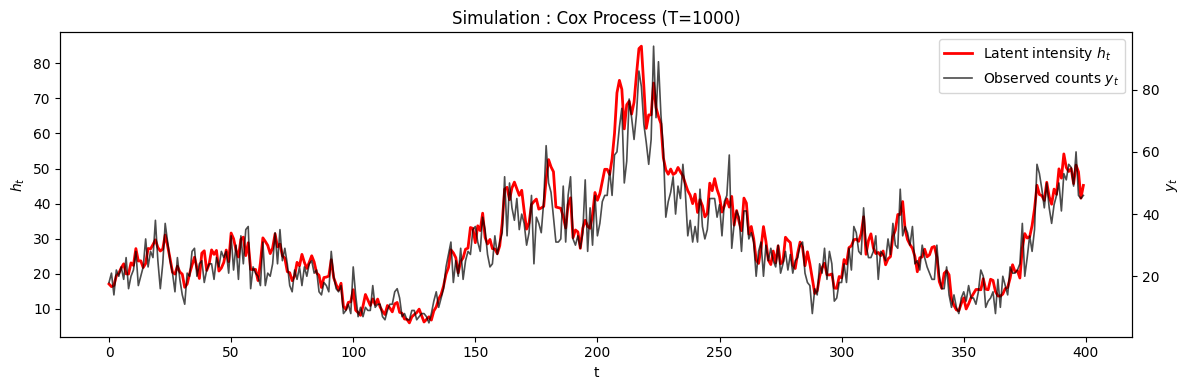

In [8]:
pl.plot_overlay_clean(y, h_true)

In [23]:
exact = ExactFilter(y, Z_trunc=Z_TRUNC)

In [24]:
# 2. Lance le MCMC
# On part des vraies valeurs ou proche pour tester
chain_results = run_metropolis_exact(
    y, 
    exact, 
    n_iterations=2500, 
    initial_theta=[0.8, 2.5, 0.5], # phi, nu, c
    proposal_std=[0.008, 0.07, 0.03] # Petits pas pour commencer
)


MCMC Sampling:  14%|█▍        | 359/2500 [06:55<41:17,  1.16s/it]


KeyboardInterrupt: 

🚀 Lancement de 10 chaînes MCMC en parallèle sur CPU...


Progression globale: 100%|██████████| 10/10 [00:00<00:00, 4225.57it/s]



--- TAUX D'ACCEPTATION PAR CHAÎNE ---
Chaîne 1: 39.50% ✅
Chaîne 2: 41.50% ✅
Chaîne 3: 40.40% ✅
Chaîne 4: 39.00% ✅
Chaîne 5: 36.00% ✅
Chaîne 6: 37.50% ✅
Chaîne 7: 38.00% ✅
Chaîne 8: 41.50% ✅
Chaîne 9: 38.90% ✅
Chaîne 10: 38.90% ✅
Moyenne globale: 39.12%

✅ Génération des graphiques...


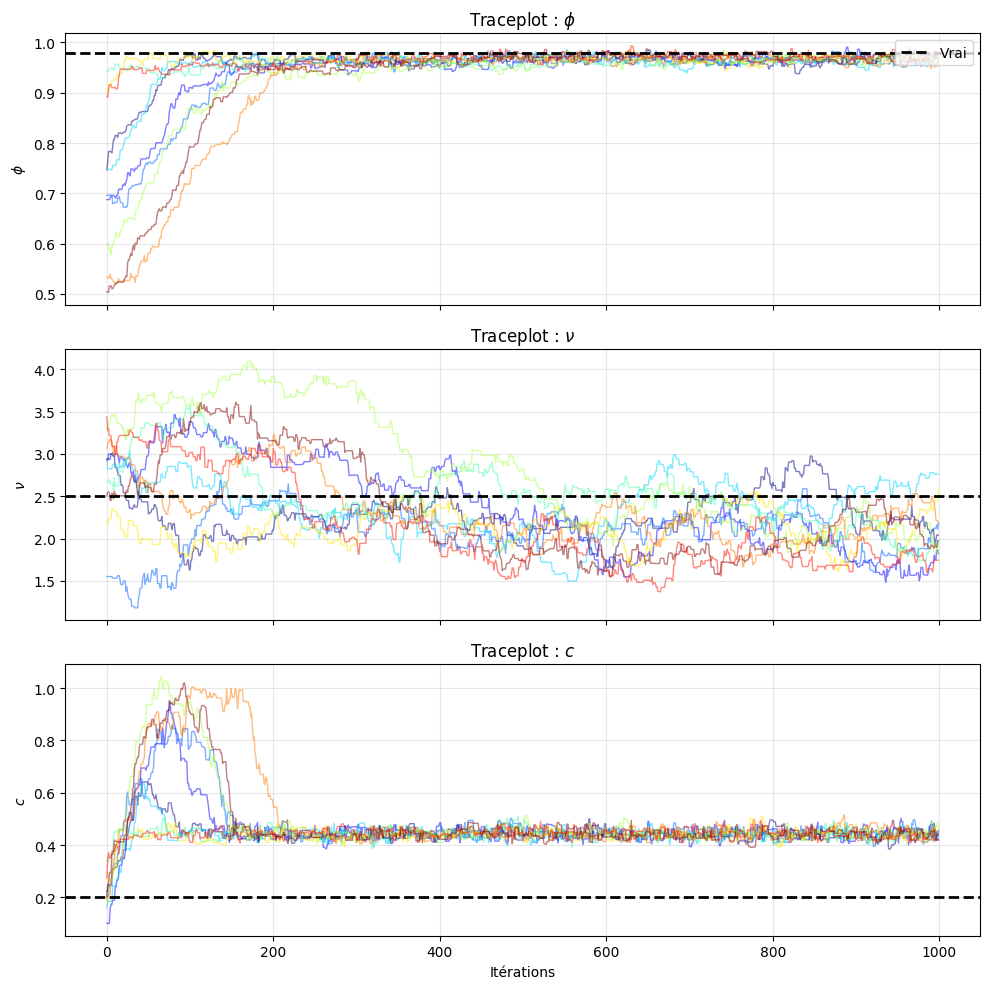


--- RÉSULTATS FINAUX (Agrégés) ---
Phi : 0.9669 +/- 0.0078
Nu  : 2.1239 +/- 0.3075
c   : 0.4424 +/- 0.0182


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# --- 1. FONCTIONS DE BASE ---

def log_prior(theta):
    """
    Définit les contraintes du modèle.
    theta = [phi, nu, c]
    """
    phi, nu, c = theta
    if 0 < phi < 0.999 and nu > 0 and c > 0:
        return 0.0
    else:
        return -np.inf

def run_metropolis_exact(y_data, exact_filter, n_iterations=5000, initial_theta=None, proposal_std=None, disable_tqdm=False):
    """
    Algorithme MCMC Random Walk Metropolis-Hastings.
    MODIFICATION : Retourne maintenant (chain, acceptance_rate)
    """
    if initial_theta is None:
        current_theta = np.array([0.5, 2.0, 0.5])
    else:
        current_theta = np.array(initial_theta)
        
    if proposal_std is None:
        proposal_std = np.array([0.02, 0.2, 0.1]) 
    
    chain = np.zeros((n_iterations, 3))
    accept_count = 0
    
    if log_prior(current_theta) == -np.inf:
        current_theta = np.array([0.5, 2.5, 0.5])
        
    current_log_prior = log_prior(current_theta)
    current_log_lik = exact_filter.log_likelihood(current_theta[0], current_theta[1], current_theta[2])
    current_log_post = current_log_lik + current_log_prior

    iterator = range(n_iterations)
    if not disable_tqdm:
        iterator = tqdm(iterator, desc="MCMC Sampling")
    
    for i in iterator:
        proposal = current_theta + np.random.normal(0, proposal_std)
        prop_log_prior = log_prior(proposal)
        
        if prop_log_prior == -np.inf:
            chain[i] = current_theta
        else:
            try:
                prop_log_lik = exact_filter.log_likelihood(proposal[0], proposal[1], proposal[2])
                prop_log_post = prop_log_lik + prop_log_prior
                
                log_alpha = prop_log_post - current_log_post
                
                if np.log(np.random.rand()) < log_alpha:
                    current_theta = proposal
                    current_log_post = prop_log_post
                    accept_count += 1
            except Exception:
                pass
        
        chain[i] = current_theta

    # CALCUL DU TAUX
    acc_rate = accept_count / n_iterations
    
    # On affiche seulement si on n'est pas en mode "silencieux" (parallèle)
    if not disable_tqdm:
        print(f"Taux d'acceptation final : {acc_rate:.2%}")
        
    # RETOURNE UN TUPLE MAINTENANT
    return chain, acc_rate

# --- 2. FONCTION PARALLÈLE (LE WORKER) ---

def _worker_chain(seed, y, exact_filter, n_iter, proposal_std):
    np.random.seed(seed)
    
    start_phi = np.random.uniform(0.5, 0.95) # Attention à 0.999 c'est risqué
    start_nu  = np.random.uniform(1.5, 3.5)
    start_c   = np.random.uniform(0.1, 0.3) # Eviter 0 pile
    start_theta = [start_phi, start_nu, start_c]
    
    # Le worker renvoie (chain, rate)
    return run_metropolis_exact(
        y_data=y,
        exact_filter=exact_filter,
        n_iterations=n_iter,
        initial_theta=start_theta,
        proposal_std=proposal_std,
        disable_tqdm=True 
    )

# --- 3. ORCHESTRATEUR MULTI-CHAÎNES ---

def run_multi_chain_mcmc(y, exact_filter, n_chains=4, n_iter=2000, proposal_std=[0.008, 0.07, 0.03], burn_in=500, true_params=None):
    print(f"🚀 Lancement de {n_chains} chaînes MCMC en parallèle sur CPU...")
    
    # Exécution parallèle
    results = Parallel(n_jobs=-1)(
        delayed(_worker_chain)(
            seed=k, 
            y=y, 
            exact_filter=exact_filter, 
            n_iter=n_iter, 
            proposal_std=proposal_std
        ) for k in tqdm(range(n_chains), desc="Progression globale")
    )
    
    # DÉCOMPOSITION DES RÉSULTATS
    # results est une liste de tuples [(chain1, rate1), (chain2, rate2), ...]
    chains = np.array([r[0] for r in results]) # On extrait juste les chaînes pour numpy
    rates = [r[1] for r in results]           # On extrait les taux
    
    # AFFICHAGE DES TAUX PROPREMENT
    print("\n--- TAUX D'ACCEPTATION PAR CHAÎNE ---")
    for k, r in enumerate(rates):
        status = "✅" if 0.2 <= r <= 0.5 else "⚠️"
        print(f"Chaîne {k+1}: {r:.2%} {status}")
    print(f"Moyenne globale: {np.mean(rates):.2%}")

    # --- VISUALISATION ---
    print("\n✅ Génération des graphiques...")
    param_names = [r'$\phi$', r'$\nu$', r'$c$']
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    colors = plt.cm.jet(np.linspace(0, 1, n_chains))
    
    for i in range(3):
        ax = axes[i]
        for k in range(n_chains):
            ax.plot(chains[k][:, i], alpha=0.5, color=colors[k], lw=1)
        
        if true_params is not None:
            ax.axhline(true_params[i], color='black', linestyle='--', linewidth=2, label='Vrai')
            
        ax.set_ylabel(param_names[i])
        ax.set_title(f"Traceplot : {param_names[i]}")
        if i == 0 and true_params is not None: ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
    plt.xlabel("Itérations")
    plt.tight_layout()
    plt.show()
    
    # --- STATISTIQUES GLOBALES ---
    all_samples = np.vstack([c[burn_in:] for c in chains])
    global_mean = all_samples.mean(axis=0)
    global_std = all_samples.std(axis=0)
    
    print("\n--- RÉSULTATS FINAUX (Agrégés) ---")
    print(f"Phi : {global_mean[0]:.4f} +/- {global_std[0]:.4f}")
    print(f"Nu  : {global_mean[1]:.4f} +/- {global_std[1]:.4f}")
    print(f"c   : {global_mean[2]:.4f} +/- {global_std[2]:.4f}")
    
    return chains

# --- UTILISATION ---
res = run_multi_chain_mcmc(y, exact, n_chains=10, n_iter=1000, true_params=[0.98, 2.5, 0.2])